# Systemy Inteligentne - projekt  
Ninejszy projekt z laboratorium Systemów Inteligentych składa się z dwóch części, obejmujących różne, choć związane ze sobą tematycznie, zagadnienia. W ramach pierwszej części, dotyczącej przewidywania wartości produkcji energii w elektrownii na podstawie wybranych danych, zrealizowane zostały dwa modele: **model regresji wielowymiarowej** oraz **model regresji wielowymiarowej interwałowej**, w którym wartość produkcji energii dzielona jest na kilka przedziałów. W ramach drugiej części zrealizowane zostało zadanie **dwukryterialnej optymalizacji rozmieszczenia wiatraków** na obszarze przy maksymalizacji wyprodukowanej energii oraz minimalizacji kosztu metodą symulowanego wyżarzania. W ramach tej części również zbudowany został model regresji uwzględniający przedział wartości produkcji energii. 

### 1. Regresja wielowymiarowa i interwałowa

**ZBIÓR DANYCH**: Zbiór danych zawiera 9568 punktów danych zebranych z elektrowni o cyklu kombinowanym na przestrzeni 6 lat (2006-2011), kiedy elektrownia została ustawiona do pracy z pełnym obciążeniem. Funkcje obejmują średnie godzinowe zmienne otoczenia Temperatura (T), Ciśnienie otoczenia (AP), Wilgotność względna (RH) i Próżnia spalin (V) w celu przewidywania godzinowej produkcji energii elektrycznej netto (EP) zakładu.
Elektrownia o cyklu kombinowanym (CCPP) składa się z turbin gazowych (GT), turbin parowych (ST) i generatorów pary z odzyskiem ciepła. W CCPP energia elektryczna jest wytwarzana przez turbiny gazowe i parowe, które są połączone w jednym cyklu i jest przesyłana z jednej turbiny do drugiej. Podczas gdy Próżnia jest zbierana i ma wpływ na Turbinę Parową, pozostałe trzy zmienne otoczenia wpływają na wydajność GT.
Dla porównania z naszymi podstawowymi badaniami i aby umożliwić przeprowadzenie 5x2-krotnych testów statystycznych, dostarczamy dane przetasowane pięć razy. Dla każdego tasowania przeprowadza się 2-krotne CV, a otrzymane 10 pomiarów wykorzystuje się do testów statystycznych.

#### 1.1 Import odpowiednich bibliotek

In [299]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns 
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import KBinsDiscretizer

#### 1.2 Wczytanie i transformacja danych

In [300]:
df = pd.read_excel('CCPP/Folds5x2_pp.xlsx')
df.head()

,AT,V,AP,RH,PE
0,14.96,41.76,1024.07,73.17,463.26
1,25.18,62.96,1020.04,59.08,444.37
2,5.11,39.40,1012.16,92.14,488.56
3,20.86,57.32,1010.24,76.64,446.48
4,10.82,37.50,1009.23,96.62,473.90


In [301]:
output_col = ['PE'] 
input_cols = list(set(list(df.columns))-set(output_col))
#df[input_cols] = df[input_cols]/df[input_cols].max() #normalizacja
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
AT,9568.0,19.651231,7.452473,1.81,13.5100,20.345,25.72,37.11
V,9568.0,54.305804,12.707893,25.36,41.7400,52.080,66.54,81.56
AP,9568.0,1013.259078,5.938784,992.89,1009.1000,1012.940,1017.26,1033.30
RH,9568.0,73.308978,14.600269,25.56,63.3275,74.975,84.83,100.16
PE,9568.0,454.365009,17.066995,420.26,439.7500,451.550,468.43,495.76


In [302]:
#sprawdzamy czy sa puste wartosci
df.isnull().sum()

AT    0
V     0
AP    0
RH    0
PE    0
dtype: int64

In [303]:
X = df[input_cols].values
y = df[output_col].values
X.shape, y.shape

((9568, 4), (9568, 1))

In [304]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=100)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)


(7654, 4) (7654, 1) (1914, 4) (1914, 1)


#### 1.3 Regrsja wielowymiarowa

Model regresji wielowymiarowej

In [305]:
model = LinearRegression()  
model.fit(X_train, y_train)
print("Współczynniki regresji:")
print(pd.DataFrame(np.round(model.coef_[0],3), input_cols).sort_values(by=0, ascending=False))
print("Wyraz wolny",np.round(model.intercept_[0],3))


Współczynniki regresji:
        0
AP  0.057
RH -0.159
V  -0.230
AT -1.986
Wyraz wolny 460.25


Predykcja

In [306]:
y_pred = model.predict(X_test)
print("Prediction: ", y_pred)

Prediction:  [[434.67788397]
 [474.93166868]
 [478.35929686]
 ...
 [465.59323186]
 [436.23881264]
 [467.38481316]]


In [307]:
# dane aktualne i przewidziane
model_diff = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': y_pred.flatten()})
model_diff.head(10)

,Actual,Predicted
0,434.31,434.677884
1,478.82,474.931669
2,473.57,478.359297
3,481.49,482.707059
4,453.22,452.442082
5,442.08,445.258734
6,432.38,428.847066
7,459.12,456.871240
8,442.60,441.842152
9,494.67,486.889182


Ocena jakości modelu

In [308]:
mean_abs_err = mean_absolute_error(y_test, y_pred)
mean_sq_err = mean_squared_error(y_test, y_pred)
print("MAE: {:.3f}" .format(mean_abs_err))
print("MSE: {:.3f}".format(mean_sq_err))
print("RMSE: {:.3f}".format(np.sqrt(mean_sq_err)))
print("R2 score: {:.3f}".format(model.score(X, y)*100))

MAE: 3.720
MSE: 23.299
RMSE: 4.827
R2 score: 92.869


Wizualizacja wyników

Feature: V, Score: -0.22958
Feature: RH, Score: -0.15867
Feature: AP, Score: 0.05652
Feature: AT, Score: -1.98576


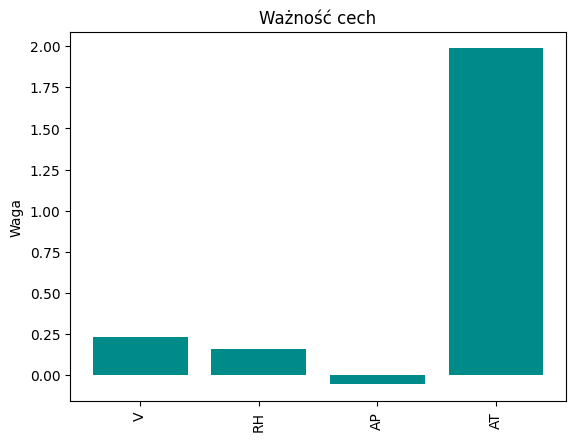

In [309]:
#ważność cech
importance = model.coef_[0]
for i,v in enumerate(importance):
    print('Feature: %0s, Score: %.5f' % (input_cols[i],v))
plt.bar([x for x in range(len(importance))], -importance, color='darkcyan')
plt.xticks(range(len(importance)), input_cols, rotation=90)
plt.title('Ważność cech')
plt.ylabel('Waga')
plt.show()


Macierz korelacji dla zmiennych niezależnych: 
           AT         V        AP        RH        PE
AT  1.000000  0.844107 -0.507549 -0.542535 -0.948128
V   0.844107  1.000000 -0.413502 -0.312187 -0.869780
AP -0.507549 -0.413502  1.000000  0.099574  0.518429
RH -0.542535 -0.312187  0.099574  1.000000  0.389794
PE -0.948128 -0.869780  0.518429  0.389794  1.000000


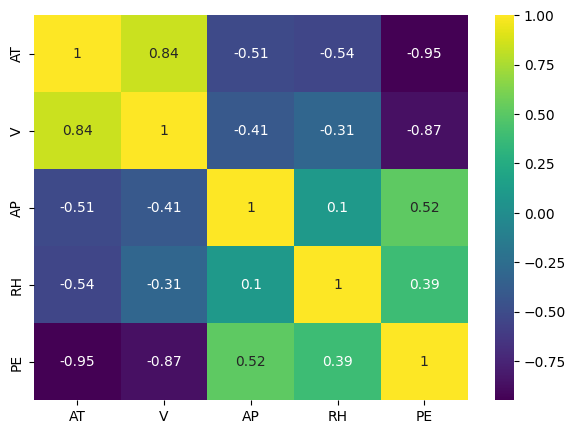

In [310]:
#mapa korelacji
corr = df.corr()
print('Macierz korelacji dla zmiennych niezależnych: \n', corr)
plt.figure(figsize=(7,5))
sns.heatmap(corr, annot=True, cmap='viridis')
plt.show()



#### 1.4 Regresja interwałowa (przedziałowa)

**Wielowymiarowa regresja interwałowa**

Regresja przedziałowa (ang. interval regression) jest metodą regresji, która jest stosowana do modelowania zależności między wieloma zmiennymi niezależnymi X i jedną zmienną zależną Y, która jest mierzona w przedziale. W przeciwieństwie do klasycznej regresji, która zakłada liniową zależność między zmiennymi niezależnymi i zależnymi, regresja przedziałowa pozwala na modelowanie nieliniowych związków między zmiennymi.

W regresji przedziałowej przedział wartości zmiennej zależnej Y jest dzielony na kilka przedziałów, a następnie modelowane są prawdopodobieństwa przynależności Y do każdego z tych przedziałów, w zależności od wartości zmiennych niezależnych X. Dzięki temu możliwe jest zastosowanie tej metody do danych, w których zmienna zależna jest mierzona w przedziale, takich jak np. ocena klienta na skali od 1 do 5. Aby przeprowadzić regresję przedziałową, należy wyznaczyć granice przedziałów dla zmiennej zależnej Y, a następnie zastosować regresję logistyczną lub inne modele statystyczne, które umożliwiają przewidywanie prawdopodobieństwa przynależności do poszczególnych przedziałów.

In [311]:
from sklearn.linear_model import BayesianRidge

#dyskretyzacja/podział zmiennej zależnej na 8 przedziałów
disctretizer = KBinsDiscretizer(n_bins=8, encode='ordinal', strategy='uniform')
Y_binned = disctretizer.fit_transform(y_train).ravel()

#model regresji liniowej dla przedziałów
IR_model =BayesianRidge()
IR_model.fit(X_train, Y_binned)



print("Współczynniki regresji:")
for name, coef in zip(df.columns, IR_model.coef_[:]):
    print(f"{name}: {coef:.3f}")

# wyświetlenie wyrazu wolnego
print(f"Wyraz wolny: {IR_model.intercept_:.3f}")

Współczynniki regresji:
AT: -0.024
V: -0.016
AP: 0.008
RH: -0.209
Wyraz wolny: 1.878


Predykcja

In [312]:
#predykcja
y_pred_binned = IR_model.predict(X_test)
y_pred2 = disctretizer.inverse_transform(y_pred_binned.reshape(-1,1)).ravel()

#wyniki
print('Wartości przewidywane:', y_pred2.reshape(-1,1))

Wartości przewidywane: [[434.41625]
 [472.16625]
 [472.16625]
 ...
 [462.72875]
 [434.41625]
 [462.72875]]


In [313]:
model_diff2 = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': y_pred2.flatten()})
model_diff2.head(10)

,Actual,Predicted
0,434.31,434.41625
1,478.82,472.16625
2,473.57,472.16625
3,481.49,481.60375
4,453.22,443.85375
5,442.08,443.85375
6,432.38,424.97875
7,459.12,453.29125
8,442.60,434.41625
9,494.67,481.60375


Ocena jakości modelu

In [314]:
from sklearn.metrics import r2_score


mean_abs_err2 = mean_absolute_error(y_test, y_pred2)
mean_sq_err2 = mean_squared_error(y_test, y_pred2)

print("MAE: {:.3f}".format(mean_abs_err2))
print("MSE: {:.3f}".format(mean_sq_err2))

# Wyznaczenie Root Mean Squared Error
rmse = np.sqrt(mean_squared_error(y_test, y_pred2))
print(f"RMSE: {rmse:.3f}")



# # Wyznaczenie R2 score
r2 = r2_score(y_test, y_pred2)
print(f"R2 score: {r2*100:.3f}")

MAE: 5.699
MSE: 50.765
RMSE: 7.125
R2 score: 82.832


Wizualizacja wyników

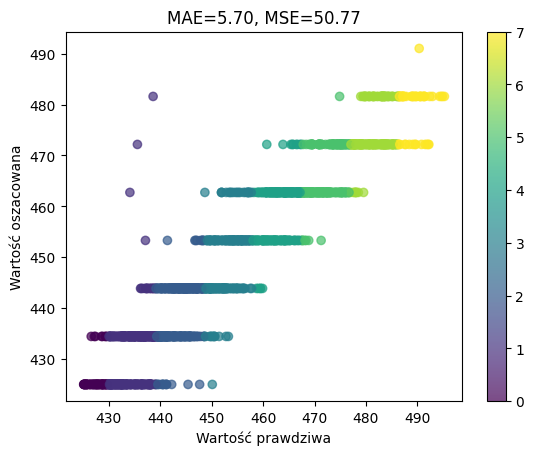

In [315]:
plt.scatter(y_test, y_pred2, c=disctretizer.transform(y_test.reshape(-1, 1)).ravel(), alpha=0.7, cmap='viridis')
plt.xlabel("Wartość prawdziwa")
plt.ylabel("Wartość oszacowana")
plt.colorbar()
plt.title(f"MAE={mean_abs_err2:.2f}, MSE={mean_sq_err2:.2f}")
plt.show()

Feature: V, Score: -0.02410
Feature: RH, Score: -0.01628
Feature: AP, Score: 0.00774
Feature: AT, Score: -0.20862


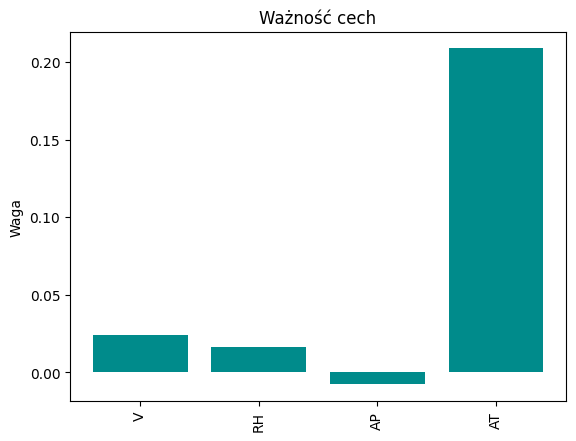

In [316]:
#ważność cech
importance = IR_model.coef_
for i,v in enumerate(importance):
    print('Feature: %0s, Score: %.5f' % (input_cols[i],v))
plt.bar([x for x in range(len(importance))], -importance, color='darkcyan')
plt.xticks(range(len(importance)), input_cols, rotation=90)
plt.title('Ważność cech')
plt.ylabel('Waga')
plt.show()


### 2. Problem rozmieszczenia wiatraków w celu maksymalizacji produkcji energii przy jednoczesnej minimalizacji kosztów

#### 2.1 Podział obszaru na m mniejszych obszarów

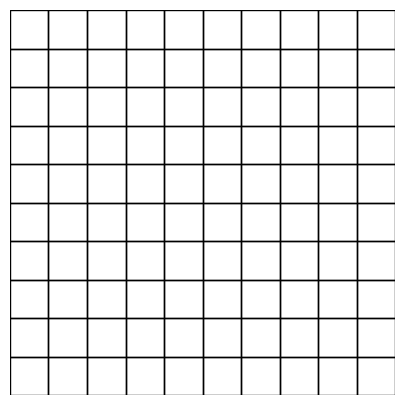

In [317]:
import matplotlib.pyplot as plt
import random

side_length = 10
num_squares = 10

sub_square_side_length = side_length / num_squares

#wizualizacja
fig, ax = plt.subplots(figsize = (5, 5))
ax.set_aspect('equal')

# iterujemy po ilości kwadratow
for i in range(num_squares):
    for j in range(num_squares):
        # wspolrzedne obecnego kwadratu
        x = i * sub_square_side_length
        y = j * sub_square_side_length

        rect = plt.Rectangle((x, y), sub_square_side_length, sub_square_side_length, linewidth=1, edgecolor='black', facecolor='none')
        ax.add_patch(rect)
        
# Granice osi x i y
ax.set_xlim([0, side_length])
ax.set_ylim([0, side_length])
ax.axis('off')
plt.show()


#### 2.2 Wygenerowanie parametrów

Na tym etapie tworzymy dwie ramki danych:  
  
1. **df_energy_per_hour**, gdzie losujemy godzinowy (24h) przedział wartosci energii dla danego obszaru;   
  
2. **df_general**, gdzie pojedynczy wiersz jest jednym obszarem. W tej ramce danych wyznaczamy ogólny przedział wartośći produkcji energii na danym obszarze ([min, max] z dobowej produkcji energii dla obszaru) oraz losujemy koszt dla każdego obszaru.    

In [318]:
import warnings

df_energy_per_hour = pd.DataFrame(columns=['Area','Hour', 'Lower Bound', 'Upper Bound']) #ramka danych dla energii kazdego obszaru w kazdej godzinie
df_general = pd.DataFrame(columns=['Area','Energy neg','Energy pos','Cost']) # ramka danych dla energii i kosztu dla kazdego obszaru

# wyłączamy ostrzeżenia
warnings.simplefilter(action='ignore', category=FutureWarning)

for i in range(num_squares**2):
    for k in range(24):
        #Generujemy losowy zakres wartosci energii dla kazdego obszaru w kazdej godzinie
        lower_bound = random.uniform(10, 50)
        upper_bound = random.uniform(lower_bound+10, lower_bound+50)
    
        data_per_hour = {
                'Area': f"{i}",
                'Hour': f"{k}",
                'Lower Bound': lower_bound,
                'Upper Bound': upper_bound
            }

        # dodajemy do ramki danych
        df_energy_per_hour = df_energy_per_hour.append(data_per_hour, ignore_index=True)

    #Bierzemy sume minimalnej i maksymalnej energii dla kazdego obszaru
    energy_neg = df_energy_per_hour['Lower Bound'].sum()
    energy_pos = df_energy_per_hour['Upper Bound'].sum()

    #Generujemy losowy koszt dla kazdego obszaru
    cost = random.uniform(1, 100)

    data_general = {
            'Area': f"{i}",
            'Energy neg': energy_neg,
            'Energy pos': energy_pos,
            'Cost': cost
    }

    # dodajemy do ramki danych
    df_general = df_general.append(data_general, ignore_index=True)


In [319]:
df_energy_per_hour

,Area,Hour,Lower Bound,Upper Bound
0,0,0,36.753706,57.648999
1,0,1,12.007552,57.838253
2,0,2,49.688794,66.276497
3,0,3,47.530054,67.744916
4,0,4,46.914275,80.684838
...,...,...,...,...
2395,99,19,22.422475,37.240893
2396,99,20,44.874435,89.487128
2397,99,21,22.325850,37.162773
2398,99,22,21.137304,47.554650


In [320]:
df_general

,Area,Energy neg,Energy pos,Cost
0,0,752.573234,1419.451092,19.115684
1,1,1501.222796,2893.703772,45.695055
2,2,2305.825459,4423.653733,91.971563
3,3,3067.011101,6052.631835,64.305487
4,4,3722.859079,7473.009151,28.233824
...,...,...,...,...
95,95,69740.466961,139199.155069,67.628333
96,96,70478.588462,140620.991146,71.806892
97,97,71207.091400,142192.567282,50.644188
98,98,71879.373629,143596.708115,28.721404


Wyświetlamy koszt i dolną oraz górną granice produkcji energii dla każdego obszaru

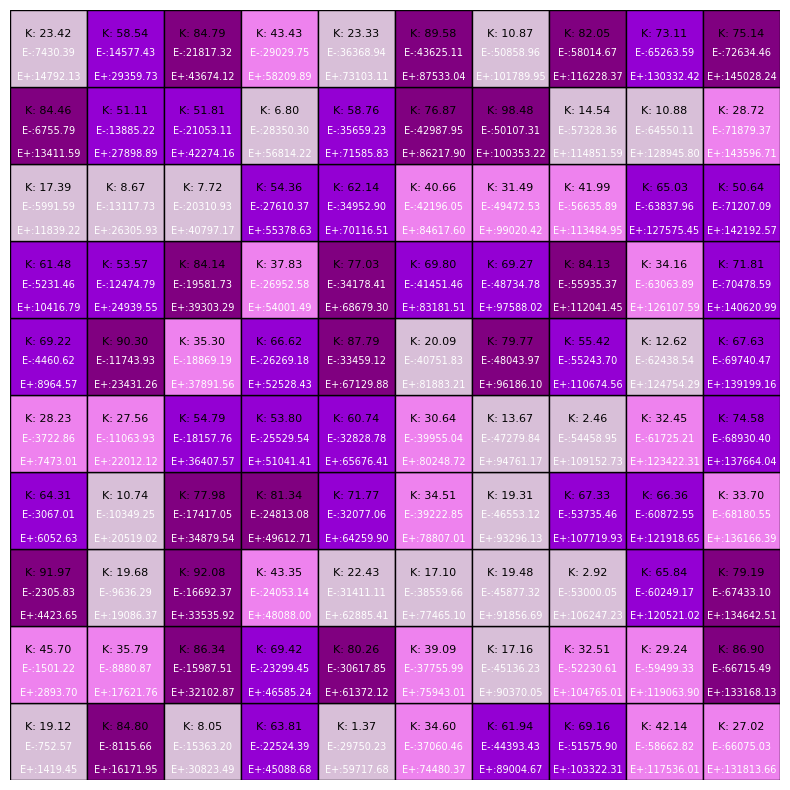

In [321]:
fig, ax = plt.subplots(figsize = (20, 10))
ax.set_aspect('equal')

# iterujemy po ilości kwadratow
for i in range(num_squares):
    for j in range(num_squares):
        # wspolrzedne obecnego kwadratu
        x = i * sub_square_side_length
        y = j * sub_square_side_length

        #wyswietlamy energie i koszt dla kazdego obszaru
        energy_neg = df_general['Energy neg'][i*num_squares+j]
        energy_pos = df_general['Energy pos'][i*num_squares+j]
        cost = df_general['Cost'][i*num_squares+j]
        #wypelniamy kwadraty kolorem zaleznie od kosztu

        if cost < 25:
            rect = plt.Rectangle((x, y), sub_square_side_length, sub_square_side_length, linewidth=1, edgecolor='black', facecolor='thistle')
            ax.text(x+0.5, y+0.75, f"K: {cost:.2f}", ha="center", va="top", color="black", fontsize=8)

        elif cost < 50:
            rect = plt.Rectangle((x, y), sub_square_side_length, sub_square_side_length, linewidth=1, edgecolor='black', facecolor='violet')
            ax.text(x+0.5, y+0.75, f"K: {cost:.2f}", ha="center", va="top", color="black", fontsize=8)

        elif cost < 75:
            rect = plt.Rectangle((x, y), sub_square_side_length, sub_square_side_length, linewidth=1, edgecolor='black', facecolor='darkviolet')    
            ax.text(x+0.5, y+0.75, f"K: {cost:.2f}", ha="center", va="top", color="black", fontsize=8)
       
        else:
            rect = plt.Rectangle((x, y), sub_square_side_length, sub_square_side_length, linewidth=1, edgecolor='black', facecolor='purple')
            ax.text(x+0.5, y+0.75, f"K: {cost:.2f}", ha="center", va="top", color="black", fontsize=8)
            
        ax.add_patch(rect)

        #wyswietlamy energie dla kazdego obszaru
        ax.text(x+0.5, y+0.5, f"E-:{energy_neg:.2f}", ha="center", va="top", color="white", fontsize=7)
        ax.text(x+0.5, y+0.2, f"E+:{energy_pos:.2f}", ha="center", va="top", color="white", fontsize=7)
        
# Granice osi x i y
ax.set_xlim([0, side_length])
ax.set_ylim([0, side_length])
ax.axis('off')
plt.show()

Text(0.5, 0.98, 'Wykres przedziału wartości energii dla przykładowych obszarów')

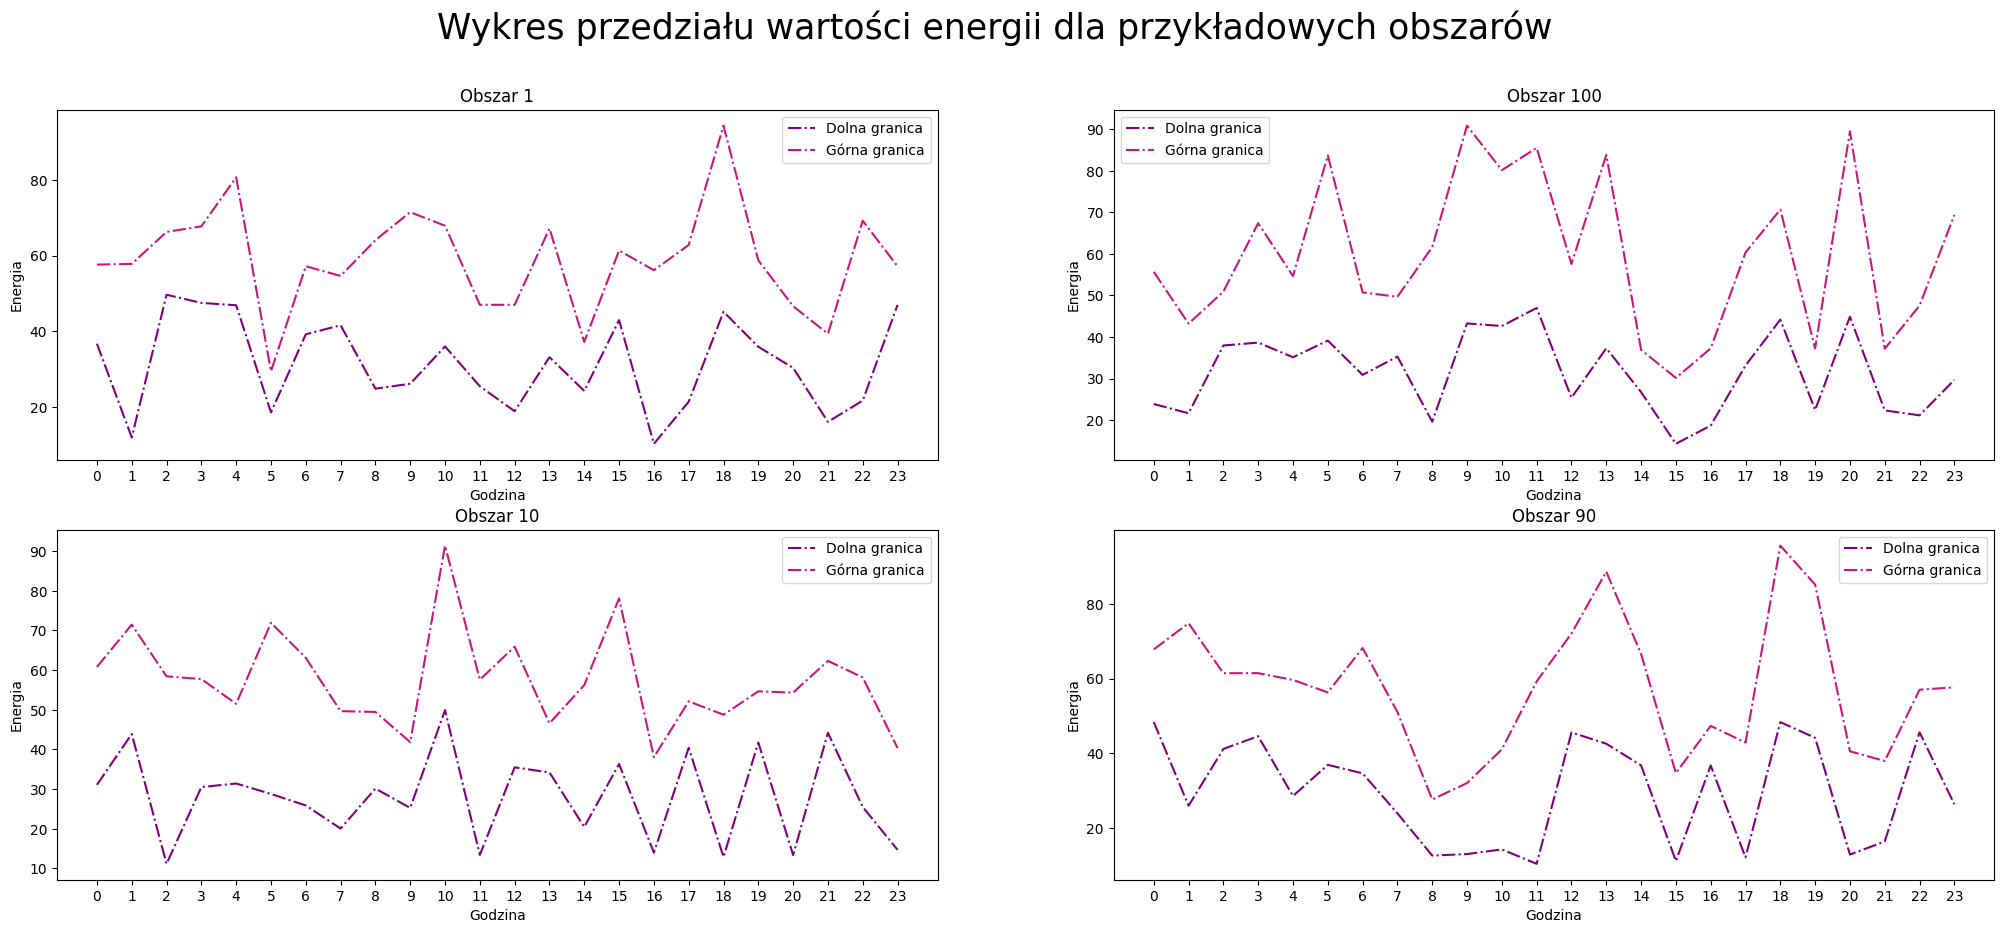

In [322]:
#wykresy czasu i energii dla pierwszego i ostatniego obszaru
fig, ax = plt.subplots(2, 2, figsize=(25, 10))

#pierwszy obszar
ax[0, 0].plot(df_energy_per_hour[df_energy_per_hour['Area'] == '0']['Hour'], df_energy_per_hour[df_energy_per_hour['Area'] == '0']['Lower Bound'], label='Dolna granica', linestyle= '-.', color ='purple')
ax[0, 0].plot(df_energy_per_hour[df_energy_per_hour['Area'] == '0']['Hour'], df_energy_per_hour[df_energy_per_hour['Area'] == '0']['Upper Bound'], label='Górna granica', linestyle= '-.', color = 'mediumvioletred')
ax[0, 0].set_title('Obszar 1')
ax[0, 0].set_xlabel('Godzina')
ax[0, 0].set_ylabel('Energia')
ax[0, 0].legend()

#ostatni obszar
ax[0, 1].plot(df_energy_per_hour[df_energy_per_hour['Area'] == '99']['Hour'], df_energy_per_hour[df_energy_per_hour['Area'] == '99']['Lower Bound'], label='Dolna granica', linestyle= '-.', color ='purple')
ax[0, 1].plot(df_energy_per_hour[df_energy_per_hour['Area'] == '99']['Hour'], df_energy_per_hour[df_energy_per_hour['Area'] == '99']['Upper Bound'], label='Górna granica', linestyle= '-.', color = 'mediumvioletred')
ax[0, 1].set_title('Obszar 100')
ax[0, 1].set_xlabel('Godzina')
ax[0, 1].set_ylabel('Energia')
ax[0, 1].legend()

#pierwszy obszar
ax[1, 0].plot(df_energy_per_hour[df_energy_per_hour['Area'] == '9']['Hour'], df_energy_per_hour[df_energy_per_hour['Area'] == '9']['Lower Bound'], label='Dolna granica', linestyle= '-.', color ='purple')
ax[1, 0].plot(df_energy_per_hour[df_energy_per_hour['Area'] == '9']['Hour'], df_energy_per_hour[df_energy_per_hour['Area'] == '9']['Upper Bound'], label='Górna granica', linestyle= '-.', color = 'mediumvioletred')
ax[1, 0].set_title('Obszar 10')
ax[1, 0].set_xlabel('Godzina')
ax[1, 0].set_ylabel('Energia')
ax[1, 0].legend()

#ostatni obszar
ax[1, 1].plot(df_energy_per_hour[df_energy_per_hour['Area'] == '89']['Hour'], df_energy_per_hour[df_energy_per_hour['Area'] == '89']['Lower Bound'], label='Dolna granica', linestyle= '-.', color ='purple')
ax[1, 1].plot(df_energy_per_hour[df_energy_per_hour['Area'] == '89']['Hour'], df_energy_per_hour[df_energy_per_hour['Area'] == '89']['Upper Bound'], label='Górna granica', linestyle= '-.', color = 'mediumvioletred')
ax[1, 1].set_title('Obszar 90')
ax[1, 1].set_xlabel('Godzina')
ax[1, 1].set_ylabel('Energia')
ax[1, 1].legend()

fig.suptitle('Wykres przedziału wartości energii dla przykładowych obszarów', fontsize=25)


#### 2.3 Regresja liniowa dla produkcji energii ograniczonej górną i dolną granicą dla każdej godziny

Użyjemy regresji liniowej do oszacowania wartości energii na podstawie relacji między dolną i górną granicą energii. Regresja liniowa dopasowuje linię do punktów danych, a następnie przewiduje wartość energii dla określonego wejścia, która jest punktem środkowym między dolną i górną granicą. Takie podejście uwzględnia związek między dolną i górną granicą i zapewnia dokładniejsze oszacowanie wartości energii w tym zakresie.

In [323]:
#tworzymy nową kolume Estimated Energy o wartosci 0
df_energy_per_hour['Estimated Energy'] = 0.0

# iterujemy po wierszach
for index, row in df_energy_per_hour.iterrows():
    # bierzemy dolna i gorna granice produkcji energii dla obecnego wiersza 
    lower_bound = row['Lower Bound']
    upper_bound = row['Upper Bound']

    # tworzymy model regresji liniowej
    model = LinearRegression()

    # dopasowujemy model do dolnej i gornej granicy jako wejscie
    model.fit([[lower_bound], [upper_bound]], [lower_bound, upper_bound])

    # estymujemy wartosci energii na podstawie modelu
    estimated_energy = model.predict([[lower_bound + (upper_bound - lower_bound) / 2]])[0]

    # updatujemu kolumne Estimated Energy w ramce danych
    df_energy_per_hour.at[index, 'Estimated Energy'] = estimated_energy


df_energy_per_hour


,Area,Hour,Lower Bound,Upper Bound,Estimated Energy
0,0,0,36.753706,57.648999,47.201353
1,0,1,12.007552,57.838253,34.922902
2,0,2,49.688794,66.276497,57.982646
3,0,3,47.530054,67.744916,57.637485
4,0,4,46.914275,80.684838,63.799556
...,...,...,...,...,...
2395,99,19,22.422475,37.240893,29.831684
2396,99,20,44.874435,89.487128,67.180782
2397,99,21,22.325850,37.162773,29.744311
2398,99,22,21.137304,47.554650,34.345977


Wizualizacja wyników regresji

Text(0.5, 0.98, 'Wykres przedziału wartości energii wraz z linią regresji dla przykładowych obszarów')

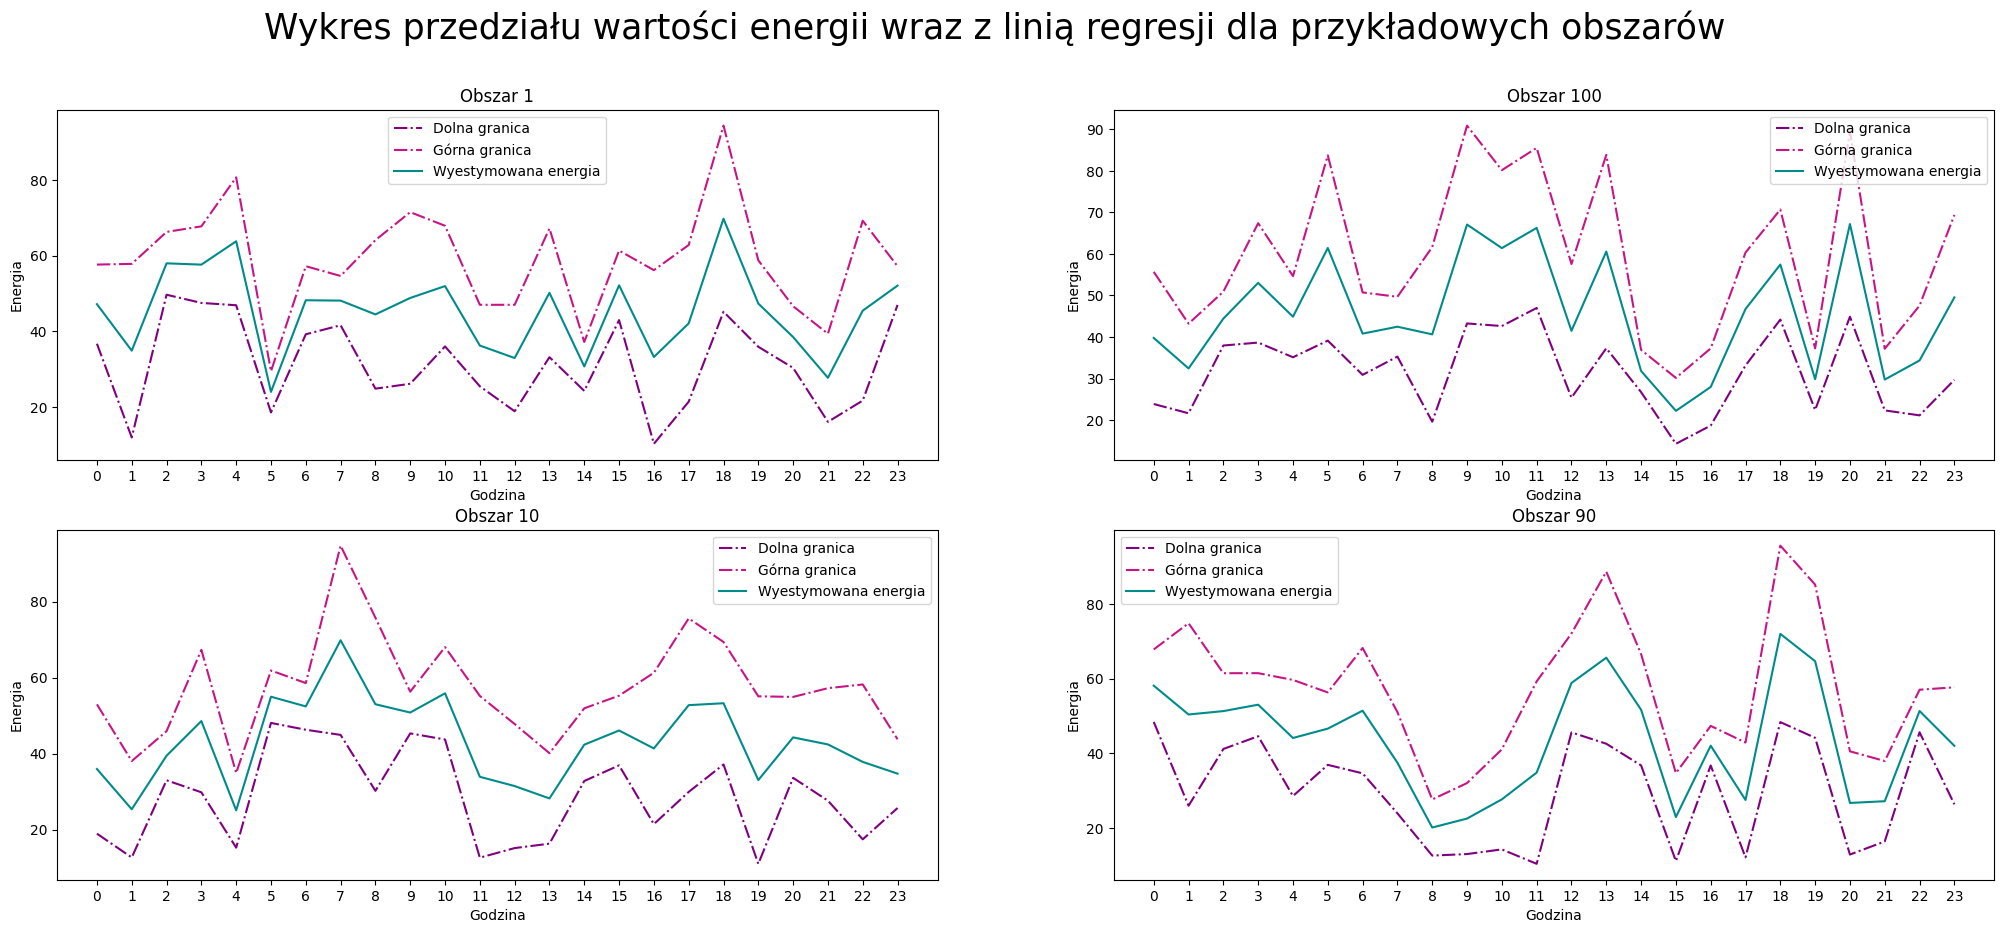

In [324]:

fig, ax = plt.subplots(2,2, figsize=(25, 10))

#pierwszy obszar
ax[0, 0].plot(df_energy_per_hour[df_energy_per_hour['Area'] == '0']['Hour'], df_energy_per_hour[df_energy_per_hour['Area'] == '0']['Lower Bound'], label='Dolna granica', linestyle= '-.', color ='purple')
ax[0, 0].plot(df_energy_per_hour[df_energy_per_hour['Area'] == '0']['Hour'], df_energy_per_hour[df_energy_per_hour['Area'] == '0']['Upper Bound'], label='Górna granica', linestyle= '-.', color = 'mediumvioletred')
ax[0,0].plot(df_energy_per_hour[df_energy_per_hour['Area'] == '0']['Hour'], df_energy_per_hour[df_energy_per_hour['Area'] == '0']['Estimated Energy'], label='Wyestymowana energia', color = 'darkcyan' )
ax[0, 0].set_title('Obszar 1')
ax[0, 0].set_xlabel('Godzina')
ax[0, 0].set_ylabel('Energia')
ax[0, 0].legend()

#ostatni obszar
ax[0, 1].plot(df_energy_per_hour[df_energy_per_hour['Area'] == '99']['Hour'], df_energy_per_hour[df_energy_per_hour['Area'] == '99']['Lower Bound'], label='Dolna granica', linestyle= '-.', color ='purple')
ax[0, 1].plot(df_energy_per_hour[df_energy_per_hour['Area'] == '99']['Hour'], df_energy_per_hour[df_energy_per_hour['Area'] == '99']['Upper Bound'], label='Górna granica', linestyle= '-.', color = 'mediumvioletred')
ax[0,1].plot(df_energy_per_hour[df_energy_per_hour['Area'] == '99']['Hour'], df_energy_per_hour[df_energy_per_hour['Area'] == '99']['Estimated Energy'], label='Wyestymowana energia', color = 'darkcyan')
ax[0, 1].set_title('Obszar 100')
ax[0, 1].set_xlabel('Godzina')
ax[0, 1].set_ylabel('Energia')
ax[0, 1].legend()

#pierwszy obszar
ax[1, 0].plot(df_energy_per_hour[df_energy_per_hour['Area'] == '10']['Hour'], df_energy_per_hour[df_energy_per_hour['Area'] == '10']['Lower Bound'], label='Dolna granica', linestyle= '-.', color ='purple')
ax[1, 0].plot(df_energy_per_hour[df_energy_per_hour['Area'] == '10']['Hour'], df_energy_per_hour[df_energy_per_hour['Area'] == '10']['Upper Bound'], label='Górna granica', linestyle= '-.', color = 'mediumvioletred')
ax[1,0].plot(df_energy_per_hour[df_energy_per_hour['Area'] == '10']['Hour'], df_energy_per_hour[df_energy_per_hour['Area'] == '10']['Estimated Energy'], label='Wyestymowana energia', color = 'darkcyan')
ax[1, 0].set_title('Obszar 10')
ax[1, 0].set_xlabel('Godzina')
ax[1, 0].set_ylabel('Energia')
ax[1, 0].legend()

#ostatni obszar
ax[1, 1].plot(df_energy_per_hour[df_energy_per_hour['Area'] == '89']['Hour'], df_energy_per_hour[df_energy_per_hour['Area'] == '89']['Lower Bound'], label='Dolna granica', linestyle= '-.', color ='purple')
ax[1, 1].plot(df_energy_per_hour[df_energy_per_hour['Area'] == '89']['Hour'], df_energy_per_hour[df_energy_per_hour['Area'] == '89']['Upper Bound'], label='Górna granica', linestyle= '-.', color = 'mediumvioletred')
ax[1,1].plot(df_energy_per_hour[df_energy_per_hour['Area'] == '89']['Hour'], df_energy_per_hour[df_energy_per_hour['Area'] == '89']['Estimated Energy'], label='Wyestymowana energia', color = 'darkcyan')
ax[1, 1].set_title('Obszar 90')
ax[1, 1].set_xlabel('Godzina')
ax[1, 1].set_ylabel('Energia')
ax[1, 1].legend()

fig.suptitle('Wykres przedziału wartości energii wraz z linią regresji dla przykładowych obszarów', fontsize=25)


#### 2.4 Optymalizacja rozmieszczenia n wiatraków na obszarze

In [325]:
# sumujemy energie dla kazdego obszaru
df_general['Estimated Energy'] = df_energy_per_hour.groupby('Area')['Estimated Energy'].sum().values

df_general

,Area,Energy neg,Energy pos,Cost,Estimated Energy
0,0,752.573234,1419.451092,19.115684,1086.012163
1,1,1501.222796,2893.703772,45.695055,1111.451121
2,2,2305.825459,4423.653733,91.971563,1032.545230
3,3,3067.011101,6052.631835,64.305487,1107.508894
4,4,3722.859079,7473.009151,28.233824,1110.014932
...,...,...,...,...,...
95,95,69740.466961,139199.155069,67.628333,1172.588263
96,96,70478.588462,140620.991146,71.806892,1079.978789
97,97,71207.091400,142192.567282,50.644188,1150.039537
98,98,71879.373629,143596.708115,28.721404,1038.211531


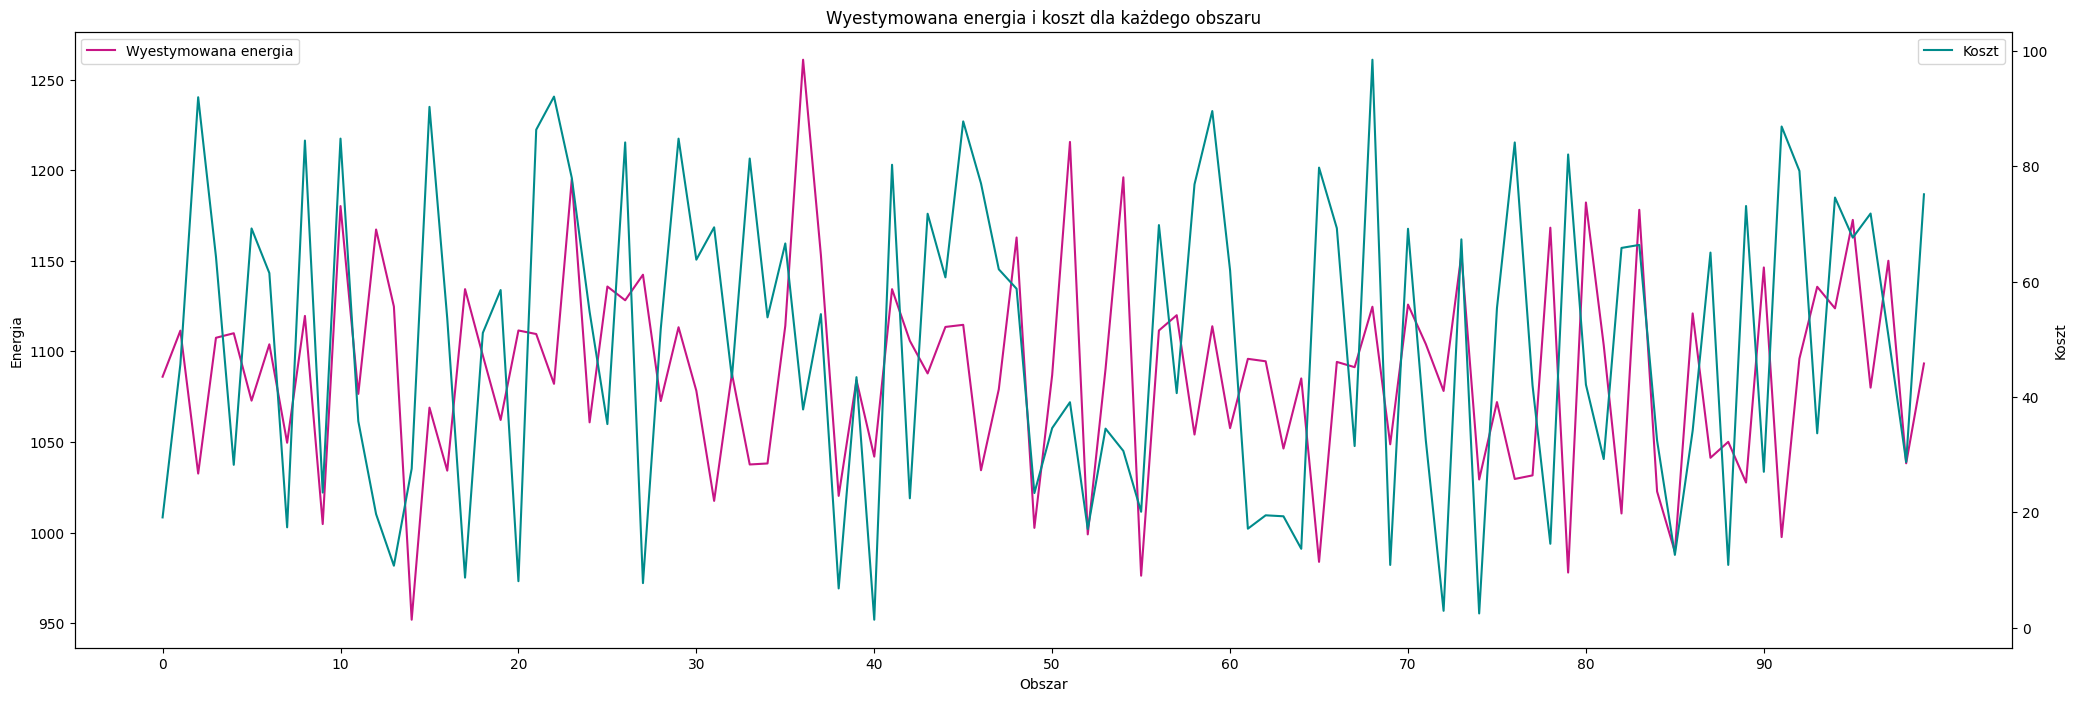

In [326]:
#show on the one plot estimated energy and cost to see the correlation
fig, ax = plt.subplots(figsize=(25, 8))

#pierwszy obszar
ax.plot(df_general['Area'], df_general['Estimated Energy'], label='Wyestymowana energia', color = 'mediumvioletred')
ax.set_title('Wyestymowana energia i koszt dla każdego obszaru')
ax.set_xlabel('Obszar')
ax.set_ylabel('Energia')
ax.set_xticks(df_general['Area'][::10])
ax.legend(loc = 'upper left')

#ostatni obszar
ax2 = ax.twinx()
ax2.plot(df_general['Area'], df_general['Cost'], label='Koszt', color = 'darkcyan')
ax2.set_ylabel('Koszt')
ax2.legend(loc = 'upper right')

Symulowane wyżarzanie

In [327]:
import random
import numpy as np

np.random.seed(42)

# Losowanie początkowego rozwiązania
def generate_initial_solution(m, n):
    return random.sample(range(m), n)

# definiujemy funkcje celu
def objective_function(allocation, column):
    total_cost = sum(df_general['Cost'].values[i] * allocation[i] for i in range(len(allocation)))
    total_energy = sum(df_general[column].values[i] * allocation[i] for i in range(len(allocation)))
    return total_cost, -total_energy

# definiujemy funkcje sąsiedztwa
def get_neighborhood(solution):
    neighborhood = []
    for i in range(len(solution)):
        for j in range(i + 1, len(solution)):
            neighbor = solution.copy()
            neighbor[i], neighbor[j] = neighbor[j], neighbor[i]
            neighborhood.append(neighbor)
    return neighborhood

# definiujemy funkcje prawdopodobieństwa akceptacji
def acceptance_probability(delta, temperature):
    return np.exp(-delta / temperature)


# Algorytm symulowanego wyżarzania
def simulated_annealing(initial_solution, max_iterations, initial_temperature, cooling_rate, column):
    cost = []
    energy = []
    iterations = []
    results = []

    current_solution = initial_solution
    best_solution = current_solution
    temperature = initial_temperature

    for iteration in range(max_iterations):
        neighborhood = get_neighborhood(current_solution)
        next_solution = random.choice(neighborhood)
        current_cost, current_energy = objective_function(current_solution, column)
        cost.append(current_cost)
        energy.append(-current_energy)
        iterations.append(iteration)
        next_cost, next_energy = objective_function(next_solution, column)
        
        if next_cost < current_cost or next_energy > current_energy:
            current_solution = next_solution
            if next_cost < current_cost and next_energy > current_energy:
                best_solution = next_solution
        else:
            delta = next_cost - current_cost
            probability = acceptance_probability(delta, temperature)
            if random.random() < probability:
                current_solution = next_solution

        temperature *= cooling_rate
    results.append(cost)
    results.append(energy)
    results.append(iterations)

    return best_solution, results


Wyniki 

In [328]:
# ustawiamy parametry
m = len(df_general)  # liczba obszarów
n = 10       # liczba wiatraków
max_iterations = 1000
initial_temperature = 100
cooling_rate = 0.95


# losujemy początkowe rozwiązanie
initial_solution = generate_initial_solution(m, n)

#symulowane wyżarzanie
best_allocation, results = simulated_annealing(initial_solution, max_iterations, initial_temperature, cooling_rate, 'Estimated Energy')
best_cost, best_energy = objective_function(best_allocation, 'Estimated Energy')

best_allocation_pesimist, results_pes = simulated_annealing(initial_solution, max_iterations, initial_temperature, cooling_rate, 'Energy neg')
best_cost_pes, best_energy_pes = objective_function(best_allocation_pesimist, 'Energy neg')

best_allocation_optymist, results_opt = simulated_annealing(initial_solution, max_iterations, initial_temperature, cooling_rate, 'Energy pos')
best_cost_opt, best_energy_opt = objective_function(best_allocation_optymist, 'Energy pos')

print('----------------------Rozwiązanie początkowe-------------------------\n')
print('Initial allocation:', initial_solution)
print('Initial cost:', objective_function(initial_solution, 'Estimated Energy')[0])
print('Initial energy:', -objective_function(initial_solution, 'Estimated Energy')[1])
print("\n")

print('----------------------Rozwiązanie optymalne-------------------------\n')
print('Best allocation:', best_allocation)
print('Best cost:', best_cost)
print('Best energy:', -best_energy)
print("\n")

print('----------------------Rozwiązanie optymalne- pesymistycznie-------------------------\n')
print('Best allocation:', best_allocation_pesimist)
print('Best cost:', best_cost_pes)
print('Best energy:', -best_energy_pes)
print("\n")

print('----------------------Rozwiązanie optymalne- optymistycznie-------------------------\n')
print('Best allocation:', best_allocation_optymist)
print('Best cost:', best_cost_opt)
print('Best energy:', -best_energy_opt)
print("\n")

----------------------Rozwiązanie początkowe-------------------------

Initial allocation: [19, 1, 68, 5, 99, 25, 77, 51, 39, 28]
Initial cost: 21081.273581845508
Initial energy: 444529.4832849401


----------------------Rozwiązanie optymalne-------------------------

Best allocation: [39, 28, 19, 77, 25, 1, 68, 99, 5, 51]
Best cost: 17018.919527898026
Best energy: 443002.15061530814


----------------------Rozwiązanie optymalne- pesymistycznie-------------------------

Best allocation: [99, 28, 77, 39, 51, 5, 1, 68, 25, 19]
Best cost: 18348.468109900892
Best energy: 1348601.2499074235


----------------------Rozwiązanie optymalne- optymistycznie-------------------------

Best allocation: [99, 39, 25, 68, 51, 19, 28, 1, 5, 77]
Best cost: 17066.510982689986
Best energy: 2836562.1524522016




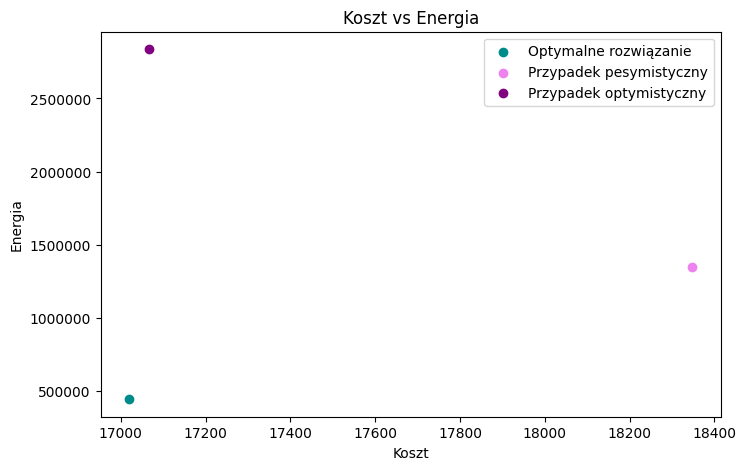

In [329]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))

plt.scatter(best_cost, -best_energy, label='Optymalne rozwiązanie', color='darkcyan')
plt.scatter(best_cost_pes, -best_energy_pes, label='Przypadek pesymistyczny', color='violet')
plt.scatter(best_cost_opt, -best_energy_opt, label='Przypadek optymistyczny', color='purple')

#plot the initial solution
#plt.scatter(objective_function(initial_solution, 'Estimated Energy')[0], -objective_function(initial_solution, 'Estimated Energy')[1], label='Initial solution', color='black')

plt.ticklabel_format(style='plain')

plt.xlabel('Koszt')
plt.ylabel('Energia')
plt.title('Koszt vs Energia')
plt.legend()

plt.show()


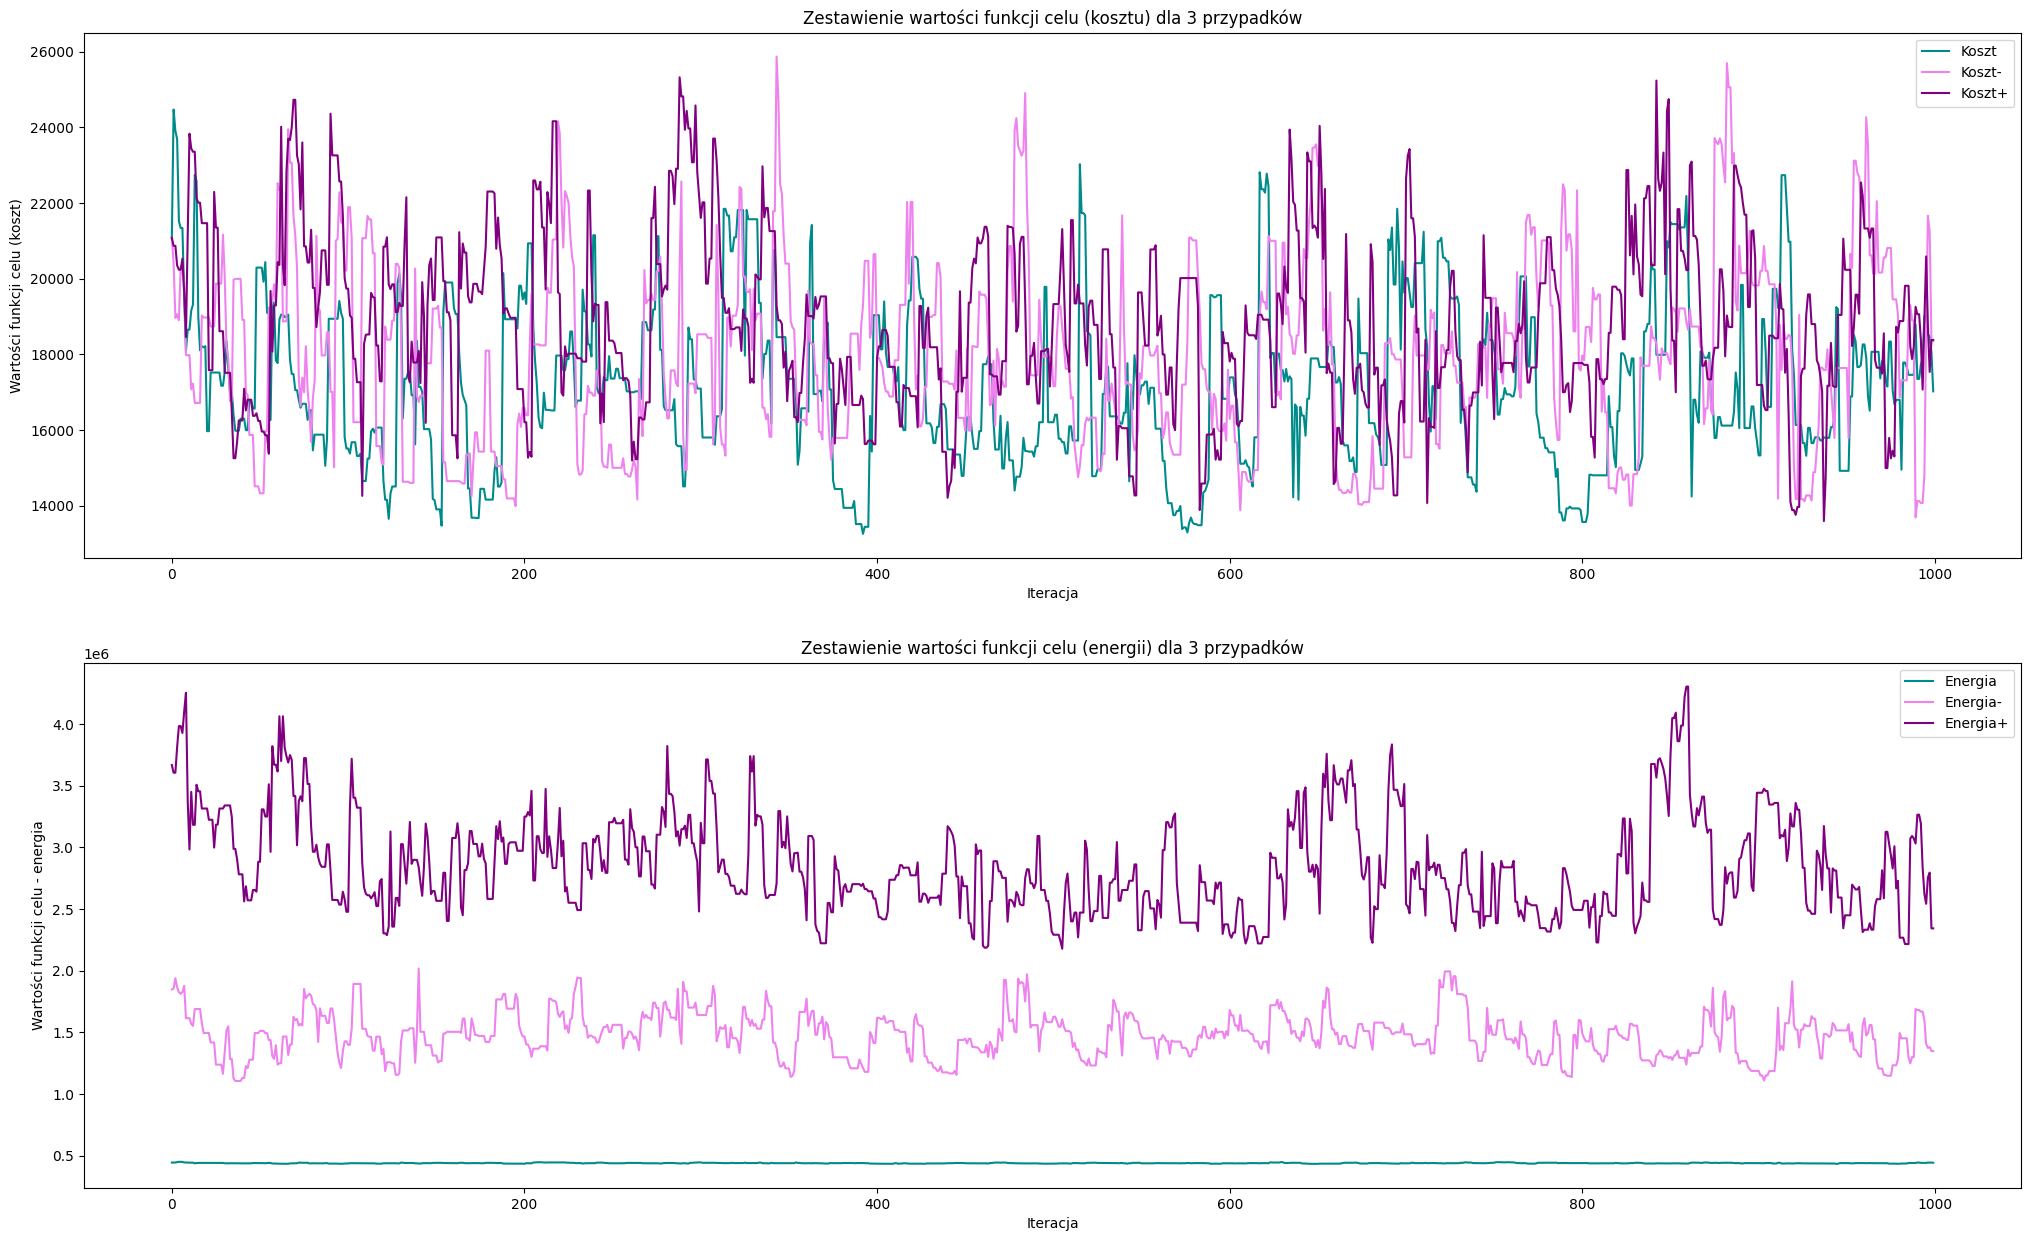

In [330]:
cost, energy, iterations = results[0], results[1], results[2]
cost_pes, energy_pes, iterations_pes = results_pes[0], results_pes[1], results_pes[2]
cost_opt, energy_opt, iterations_opt = results_opt[0], results_opt[1], results_opt[2]

fig, ax = plt.subplots(2, 1 , figsize=(25, 15))
# Create the convergence plot
ax[0].plot(iterations, cost, label='Koszt', color='darkcyan')
ax[0].plot(iterations_pes, cost_pes, label='Koszt-', color='violet')
ax[0].plot(iterations_opt, cost_opt, label='Koszt+', color='purple')
ax[0].set_xlabel('Iteracja')
ax[0].set_ylabel('Wartości funkcji celu (koszt)')
ax[0].set_title('Zestawienie wartości funkcji celu (kosztu) dla 3 przypadków')
ax[0].legend()

# Create the energy plot
ax[1].plot(iterations, energy, label='Energia', color='darkcyan')
ax[1].plot(iterations, energy_pes, label='Energia-', color='violet')
ax[1].plot(iterations, energy_opt, label='Energia+', color='purple')
ax[1].set_xlabel('Iteracja')
ax[1].set_ylabel('Wartości funkcji celu - energia')
ax[1].set_title('Zestawienie wartości funkcji celu (energii) dla 3 przypadków')
ax[1].legend()

plt.show()

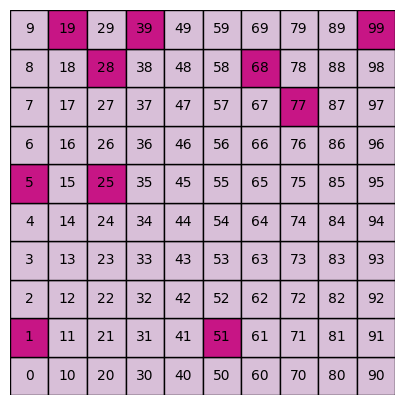

In [332]:
import matplotlib.pyplot as plt
import random

side_length = 10
num_squares = 10

sub_square_side_length = side_length / num_squares

#wizualizacja
fig, ax = plt.subplots(figsize = (5, 5))
ax.set_aspect('equal')

# iterujemy po ilości kwadratow
for i in range(num_squares):
    for j in range(num_squares):
        # wspolrzedne obecnego kwadratu
        x = i * sub_square_side_length
        y = j * sub_square_side_length

        if i * num_squares + j in best_allocation_pesimist:
            rect = plt.Rectangle((x, y), sub_square_side_length, sub_square_side_length, linewidth=1, edgecolor='black', facecolor='mediumvioletred')
            #dodajemy number obszaru
            ax.text(x + sub_square_side_length / 2, y + sub_square_side_length / 2, str(i * num_squares + j), fontsize=10, horizontalalignment='center', verticalalignment='center')
        else:
            rect = plt.Rectangle((x, y), sub_square_side_length, sub_square_side_length, linewidth=1, edgecolor='black', facecolor='thistle')
            #dodajemy number obszaru
            ax.text(x + sub_square_side_length / 2, y + sub_square_side_length / 2, str(i * num_squares + j), fontsize=10, horizontalalignment='center', verticalalignment='center')
    
        ax.add_patch(rect)
        
# Granice osi x i y
ax.set_xlim([0, side_length])
ax.set_ylim([0, side_length])
ax.axis('off')
plt.show()
